# Card Abstraction Exploratory Notebook
This notebook is an initial exploration of how one could perform card abstraction. I was reading over the "Potential-Aware Imperfect-Recall Abstraction with Earth Mover's Distance in Imperfect-Information Games", where they used a custom Earth Mover's Distance metric to perform K-Means Clustering. 

They talked about how computing EMD was extremely slow. I found a variant of it which attempts to fix this by making the problem convex and using the Sinkhorn Divergence. In the end, I found this to still be too slow for my application, and proceeded with standard K-Means clustering using Euclidean Distance. The actual clusters are visualized in a separate notebook `abstraction_visualization.ipynb`. 

## Part 1: Exploration with EMD for K-Means Clustering
Below, I try to under how the Earth Mover's Distance (EMD) is actually calculated thanks to the Python Optimal Transport Library. They generate the transport matrix, but you need to multiply that transport matrix by the actual cost matrix, so your final cost matrix.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ot
import time

In [2]:
# The distance to move each bin of the histogram independent of what the actual values are. 
# Think about it this way: it's how much you need to walk to move something, not how much weight you are actually carrying.
n = 5  # number of bins
pos_a = np.array([[i] for i in range(n)])
pos_b = np.array([[i] for i in range(n)])

C = ot.dist(pos_a, pos_b, metric='euclidean')
def plot_cost(C):
	plt.figure(figsize=(12,7))
	ax = plt.subplot(131)
	im = plt.imshow(C, cmap='coolwarm')
	plt.title('Cost Matrix')
	cbar = plt.colorbar(im, ax=ax, shrink=0.5, use_gridspec=True)
	cbar.ax.set_ylabel("cost", rotation=-90, va="bottom")

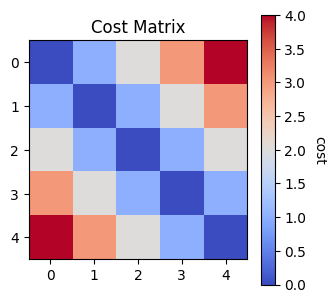

In [3]:
plot_cost(C)

Cost: 4.0


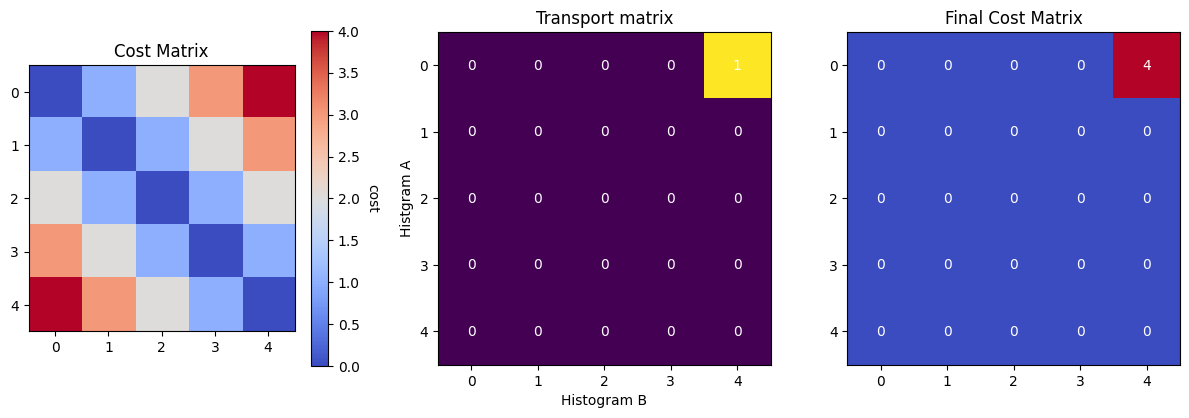

In [6]:
plot_cost(C)
# 1 vs 1. Sample
a_hist = np.array([1.0,0,0,0,0])
b_hist = np.array([0,0,0,0,1.0])
ot_emd = ot.emd(a_hist, b_hist, C)
ax = plt.subplot(132)
im = plt.imshow(ot_emd)
for i in range(n):
    for j in range(n):
        text = ax.text(j, i, '{0:g}'.format(ot_emd[i, j]),
                       ha="center", va="center", color="w")
plt.title('Transport matrix')
plt.xlabel('Histogram B')
plt.ylabel('Histgram A')
plt.tight_layout()
# The cost would be how much you are transporting for each, multipled by the original cost matrix

ax =plt.subplot(133)
transport_cost_matrix = ot_emd * C
plt.imshow(transport_cost_matrix, cmap='coolwarm')
for i in range(n):
    for j in range(n):
        text = ax.text(j, i, '{0:g}'.format(transport_cost_matrix[i, j]),
                       ha="center", va="center", color="w")

plt.title('Final Cost Matrix')
print(f'Cost: {transport_cost_matrix.sum()}')

## Part 2: Finding Optimal Number of Clusters
After I got a solid understanding of how the EMD was computed, I tried to actually implement it with K-Means. However, I found that K-Means was really extremely slowly (~10 mins per iteration). I decided in the end to proceed with the standard Euclidean distance as a metric. My rationalization is that given enough clusters, we should still be able to represent the various cases relatively well. 

Below is a study of the optimal number of clusters we should be using. I used the `yellowbrick` Python Library, where they have helper functions to use the Elbow Method and calculate intercluster distances.

In [ ]:
def plot_equity_hist(equity_hist, player_cards=None, community_cards=None):
	"""Plot the equity histogram.
	"""
	plt.clf() # Clear Canvas
	plt.hist([i/len(equity_hist) for i in range(len(equity_hist))],[i/len(equity_hist) for i in range(len(equity_hist)+1)], weights=equity_hist)
	plt.ylabel("Probability Mass")
	plt.xlabel("Equity Interval")
	if player_cards:
		player_string = "\nPlayer Cards: " + str(player_cards)
	else:
		player_string = ""
	
	if community_cards:
		community_string = "\nCommunity Cards: " + str(community_cards)
	else:
		community_string = ""

	plt.title("Equity Distribution" + player_string + community_string)
	plt.show(block=False) # to plot graphs consecutively quickly with non-blocking behavior
	plt.pause(0.2)

: 

: 

: 

In [1]:

import sys
import joblib
import os
sys.path.append("../")
import numpy as np
from abstraction import get_filenames, kmeans, kmeans_predict

In [30]:
stage = "flop"
raw_dataset_filenames = get_filenames(f'../data/raw/{stage}')
raw_dataset_filenames = sorted(raw_dataset_filenames)
filename = raw_dataset_filenames[-1]
flop_equity_distributions = np.load(f'../data/raw/{stage}/{filename}')
stage = "turn"
raw_dataset_filenames = get_filenames(f'../data/raw/{stage}')
raw_dataset_filenames = sorted(raw_dataset_filenames)
filename = raw_dataset_filenames[-1]
turn_equity_distributions = np.load(f'../data/raw/{stage}/{filename}')
stage = "river"
raw_dataset_filenames = get_filenames(f'../data/raw/{stage}')
raw_dataset_filenames = sorted(raw_dataset_filenames)
filename = raw_dataset_filenames[-1]
river_equity_distributions = np.load(f'../data/raw/{stage}/{filename}')
print(flop_equity_distributions.shape)
print(turn_equity_distributions.shape)
print(river_equity_distributions.shape)

(100000, 5)
(100000, 5)
(100000, 5)


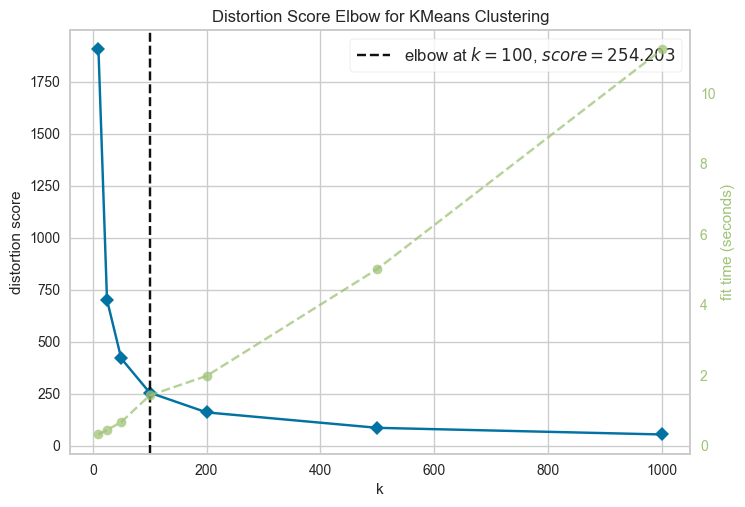

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

# Generate synthetic dataset with 8 random clusters
# # Instantiate the clustering model and visualizer
model = KMeans(n_init=1)
visualizer = KElbowVisualizer(model, k=[10, 25, 50, 100, 200, 500, 1000])
visualizer.fit(flop_equity_distributions)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

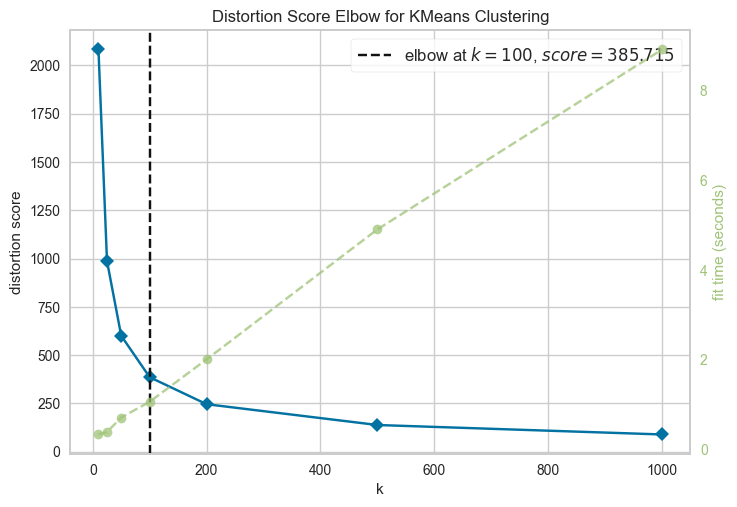

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
model = KMeans(n_init=1)
visualizer = KElbowVisualizer(model, k=[10, 25, 50, 100, 200, 500, 1000])
visualizer.fit(turn_equity_distributions)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

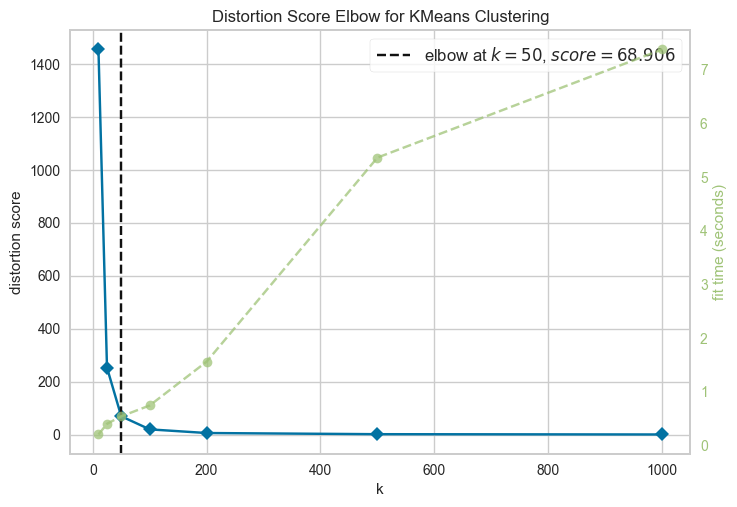

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
model = KMeans(n_init=1)
visualizer = KElbowVisualizer(model, k=[10, 25, 50, 100, 200, 500, 1000])
visualizer.fit(river_equity_distributions)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

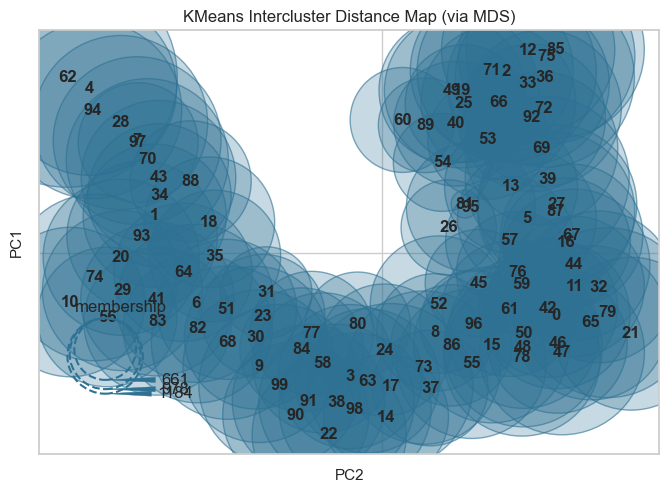

<AxesSubplot: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [34]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import InterclusterDistance

# Generate synthetic dataset with 12 random clusters

# Instantiate the clustering model and visualizer
model = KMeans(100, n_init=1)
visualizer = InterclusterDistance(model)

visualizer.fit(turn_equity_distributions)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

I will proceed with 50 clusters for flop and turn, and 10 for river (river doesn't need equity distribution). It seems to be a good balance between speed and performance.